<a href="https://colab.research.google.com/github/manickam2006/Cracking-the-market-code-with-AI-driven-stock-price-prediction-using-time-series-analysis/blob/main/cn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install gradio pandas numpy matplotlib statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.2 MB/s eta 0:00:00


Saving AAPL(80-24) Final (1).csv to AAPL(80-24) Final (1).csv


<ipython-input-2-c3641f487f9a>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[price_column].fillna(method='pad', inplace=True)  # Fill any missing values
<ipython-input-2-c3641f487f9a>:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[price_column].fillna(method='pad', inplace=True)  # Fill any missing values


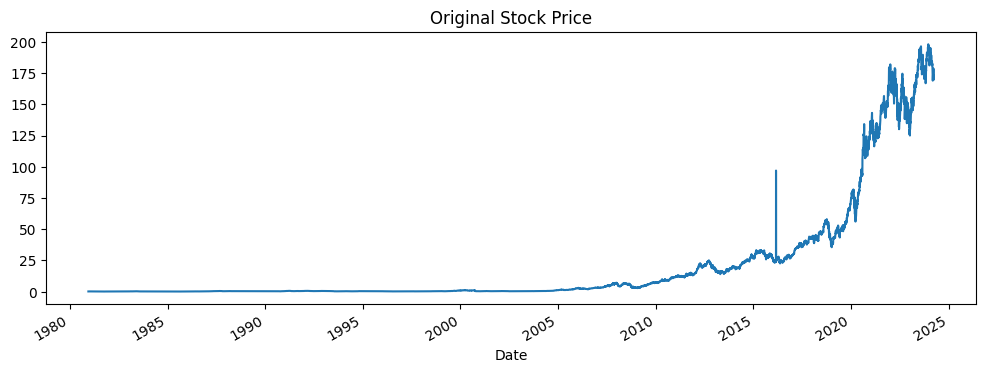


Testing Stationarity on Original Data:
ADF Statistic: 2.100854677511404
p-value: 0.9987904895667638
Critical Value (1%): -3.4309496919115574
Critical Value (5%): -2.861805030579229
Critical Value (10%): -2.5669110706464684

Testing Stationarity on Differenced Log Data:
ADF Statistic: -27.319857948585923
p-value: 0.0
Critical Value (1%): -3.4309502423688087
Critical Value (5%): -2.8618052738262367
Critical Value (10%): -2.566911200126399


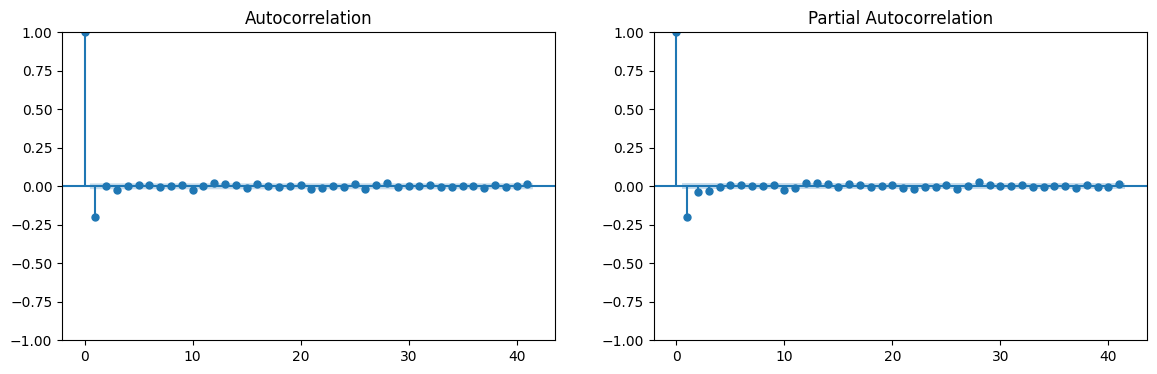

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


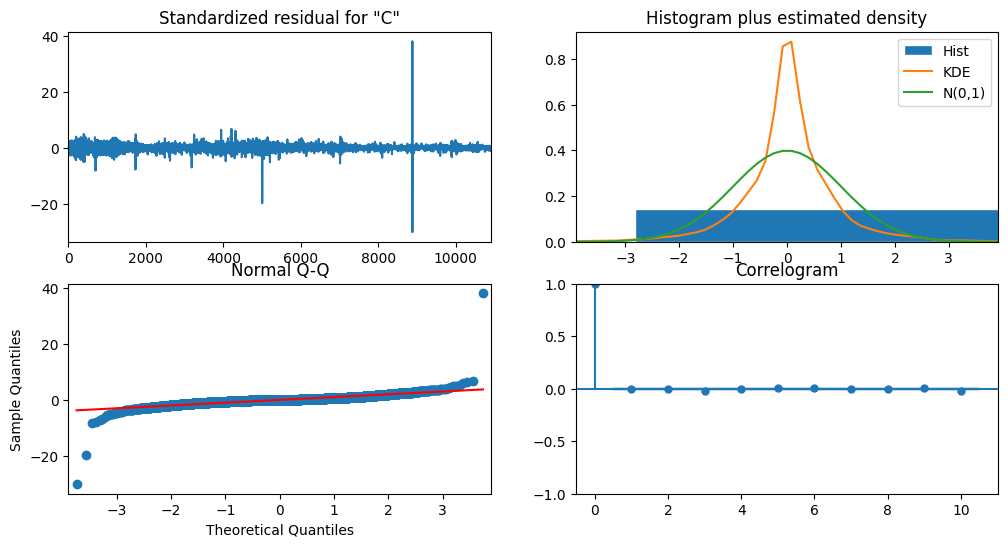

<ipython-input-2-c3641f487f9a>:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pred_log = ts_log.shift().fillna(method='bfill') + pred_log_diff


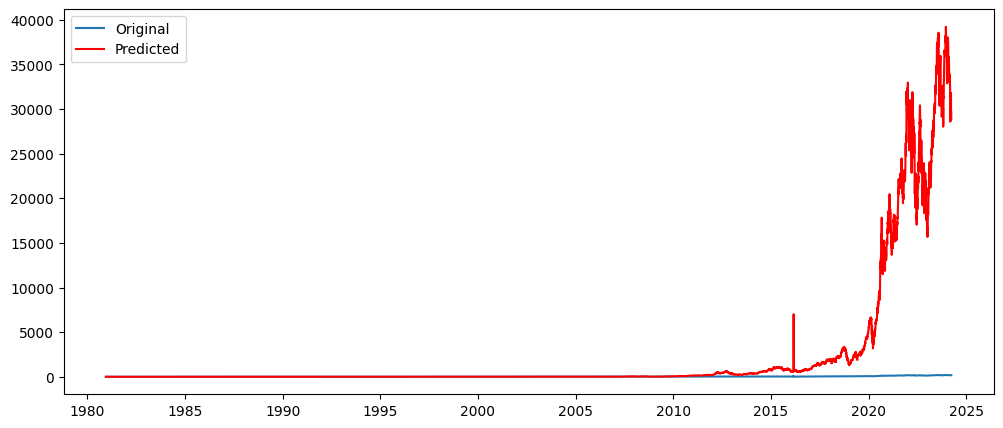

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import io
from google.colab import files  # If using Google Colab

# 1. Load data
def load_data(file_object):
    df = pd.read_csv(file_object, parse_dates=['Date'], index_col='Date')

    # Check if 'Close' column exists, otherwise use 'Price'
    if 'Close' in df.columns:
        price_column = 'Close'
    else:
        price_column = 'Price'  # Assuming 'Price' is the correct column name

    df = df[[price_column]].sort_index()  # Select the appropriate column
    df[price_column].fillna(method='pad', inplace=True)  # Fill any missing values

    # Rename the column to 'Close' for consistency
    df = df.rename(columns={price_column: 'Close'})

    return df

# 2. Plot raw time series
def plot_series(ts, title='Time Series'):
    ts.plot(figsize=(12, 4))
    plt.title(title)
    plt.show()

# 3. Test stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')

# 4. Log transform and differencing
def transform_series(ts):
    ts_log = np.log(ts)
    ts_log_diff = ts_log - ts_log.shift()
    ts_log_diff.dropna(inplace=True)
    return ts_log, ts_log_diff

# 5. Plot ACF and PACF
def plot_acf_pacf(ts_diff):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    plot_acf(ts_diff, ax=ax[0])
    plot_pacf(ts_diff, ax=ax[1])
    plt.show()

# 6. Train ARIMA
def train_arima(ts_log, order=(1, 1, 1)):
    model = ARIMA(ts_log, order=order)
    results = model.fit()
    results.plot_diagnostics(figsize=(12, 6))
    plt.show()
    return results

# 7. Forecast and inverse transform
def forecast(results, ts_log, original_ts):
    pred_log_diff = results.fittedvalues
    pred_log = ts_log.shift().fillna(method='bfill') + pred_log_diff
    predictions = np.exp(pred_log)
    plt.figure(figsize=(12, 5))
    plt.plot(original_ts, label='Original')
    plt.plot(predictions, label='Predicted', color='red')
    plt.legend()
    plt.show()

# 8. Main
if __name__ == "__main__":
    uploaded = files.upload()  # Use files.upload() for Google Colab
    file_name = list(uploaded.keys())[0]
    file_object = io.BytesIO(uploaded[file_name])

    df = load_data(file_object)
    ts = df['Close']
    plot_series(ts, title='Original Stock Price')

    print("\nTesting Stationarity on Original Data:")
    test_stationarity(ts)

    ts_log, ts_log_diff = transform_series(ts)
    print("\nTesting Stationarity on Differenced Log Data:")
    test_stationarity(ts_log_diff)

    plot_acf_pacf(ts_log_diff)

    arima_model = train_arima(ts_log, order=(1, 1, 1))
    forecast(arima_model, ts_log, ts)